In [1]:
import pathlib
import random

import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import matplotlib.pyplot as plt

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
train_path = 'picture/train'
val_path = 'picture/validation'

In [4]:
batch_size = 128
epochs = 2
IMG_HEIGHT = 192
IMG_WIDTH = 192

In [5]:
train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5)

val_image_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_data_gen = train_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_path,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse')

val_data_gen = val_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse')

Found 492 images belonging to 16 classes.
Found 181 images belonging to 16 classes.


In [7]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
mobile_net.trainable=False

In [9]:
def create_model():
    model = models.Sequential([
        mobile_net,
        layers.GlobalAveragePooling2D(),
        layers.Dense(16, activation = 'softmax')
        # layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # layers.MaxPooling2D(),
        # layers.Dropout(0.2),
        # layers.Conv2D(32, 3, padding='same', activation='relu'),
        # layers.MaxPooling2D(),
        # layers.Conv2D(64, 3, padding='same', activation='relu'),
        # layers.MaxPooling2D(),
        # layers.Dropout(0.2),
        # layers.Flatten(),
        # layers.Dense(512, activation='relu'),
        # layers.Dense(16, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
Total params: 2,278,480
Trainable params: 20,496
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model_log = model.fit_generator(
    train_data_gen,
    steps_per_epoch=492,
    epochs=epochs,
    # callbacks=[cp_callback]
    validation_data=val_data_gen,
    validation_steps=181
)

Epoch 1/2
  4/492 [..............................] - ETA: 3:25:05 - loss: 2.8402 - accuracy: 0.1077

KeyboardInterrupt: 

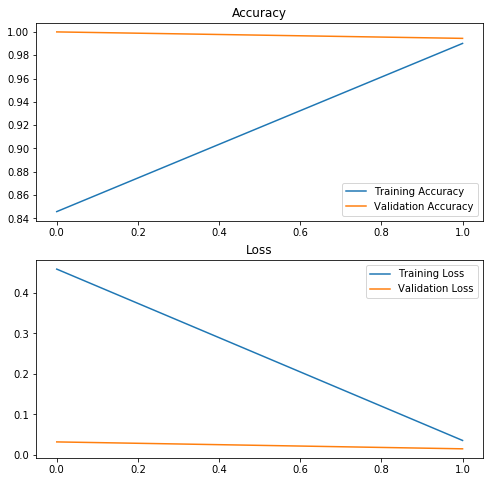

In [13]:
acc = model_log.history['accuracy']
val_acc = model_log.history['val_accuracy']

loss = model_log.history['loss']
val_loss = model_log.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.savefig('pic_A&L.jpg')
plt.show()

In [14]:
model.save('picture_model_20200118.h5')

In [15]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [150, 150])
    image /= 255.0
    return image

In [16]:
def show_image(path):
    plt.figure(figsize=(8,8))
    plt.imshow(load_image(path))
    plt.grid(False)
    plt.show()

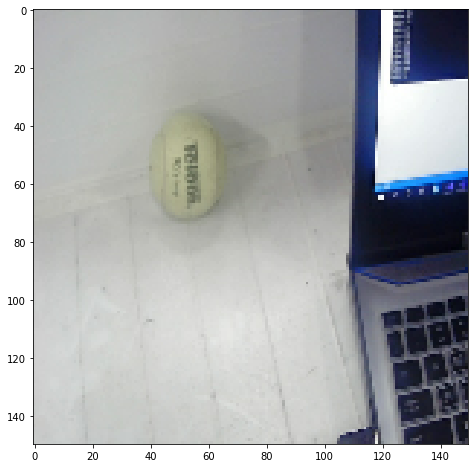

In [17]:
test_path = 'picture/test/1.jpg'
test_img = load_image(test_path)
test_img = np.reshape(test_img, (1, IMG_HEIGHT, IMG_WIDTH, 3))

show_image(test_path)

In [18]:
pre = model.predict(test_img)
print(pre)
print("predict: ", np.argmax(pre))

[[1.1920929e-07 1.1920929e-07 0.0000000e+00 2.6822090e-07 8.9406967e-08
  2.9802322e-08 1.4901161e-06 1.1920929e-07 1.9073486e-06 0.0000000e+00
  1.4305115e-06 0.0000000e+00 8.5145235e-05 0.0000000e+00 0.0000000e+00
  0.0000000e+00]]
predict:  12
